#**유통 판매량 예측 및 재고 최적화**
## **단계1 : 데이터 탐색 및 가설 도출**

# **0.미션**

* 예측해야 할 핵심상품 역할 분담
    * 핵심상품 별로, 데이터 탐색, 가설수립, 데이터셋 구성
    * 1인당 1~2개 정도를 분담하여 개별 과제 수행
    * 팀 미팅을 통해 진행 사항 공유 및 취합

* 데이터 탐색 및 가설 도출
    * 주어진 데이터에 대해 대상 매장, 대상 상품의 그래프 그리고 시계열 패턴을 찾기
    * 찾은 패턴을 기반으로 가설 도출

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
path = '/content/drive/MyDrive/project/'

### **(2) 라이브러리 설치 및 불러오기**

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

### **(3) 데이터 불러오기**

#### 1) 데이터로딩

In [45]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

#### 2) 기본 정보 조회

In [46]:
oil_price.head()

,Date,WTI_Price
0,2014-01-01,NaN
1,2014-01-02,95.14
2,2014-01-03,93.66
3,2014-01-06,93.12
4,2014-01-07,93.31


In [47]:
orders[orders['Store_ID']==44]

,Date,Store_ID,CustomerCount
39,2014-01-02,44,4422
86,2014-01-03,44,4167
133,2014-01-04,44,5341
180,2014-01-05,44,5123
227,2014-01-06,44,3917
...,...,...,...
57336,2017-02-24,44,4549
57389,2017-02-25,44,4619
57442,2017-02-26,44,3877
57495,2017-02-27,44,3961


In [48]:
sales[(sales['Product_ID']==42) & (sales['Store_ID']==44)]

,Date,Store_ID,Qty,Product_ID
658,2014-01-01,44,51.0,42
1469,2014-01-02,44,76.0,42
2280,2014-01-03,44,74.0,42
3091,2014-01-04,44,78.0,42
3902,2014-01-05,44,88.0,42
...,...,...,...,...
930878,2017-02-24,44,91.0,42
931689,2017-02-25,44,105.0,42
932500,2017-02-26,44,108.0,42
933311,2017-02-27,44,78.0,42


In [49]:
products[products['Product_ID']==42]

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
15,42,FM001,Agricultural products,Grocery,2,5


In [50]:
stores[stores['Store_ID']==44]

,Store_ID,City,State,Store_Type
43,44,Saint Paul,\tMinnesota,1


# **2.데이터 탐색**

* 시계열 패턴을 찾아보기 위한 그래프를 그려 봅시다.

## **(1) 시계열 패턴 찾아보기1**

* 다음 항목은 패턴을 찾기 위한 예제 문항 입니다. 참조하여 시계열 패턴을 찾아 봅시다.
    * 대상 매장(44), 대상 상품(3,12,42)의 판매량 추이
    * 대상 상품의 동일 카테고리의 상품별 판매량 추이
    * 휘발류 가격과 상품 판매량 추이 비교
    * 방문 고객수와 상품 판매량 추이 비교
    * 그외...

### 1) 대상 매장(44), 대상 상품의 판매량 추이

In [51]:
# 데이터 기간은 다음과 같습니다.
sales.Date.min(), sales.Date.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2017-02-28 00:00:00'))

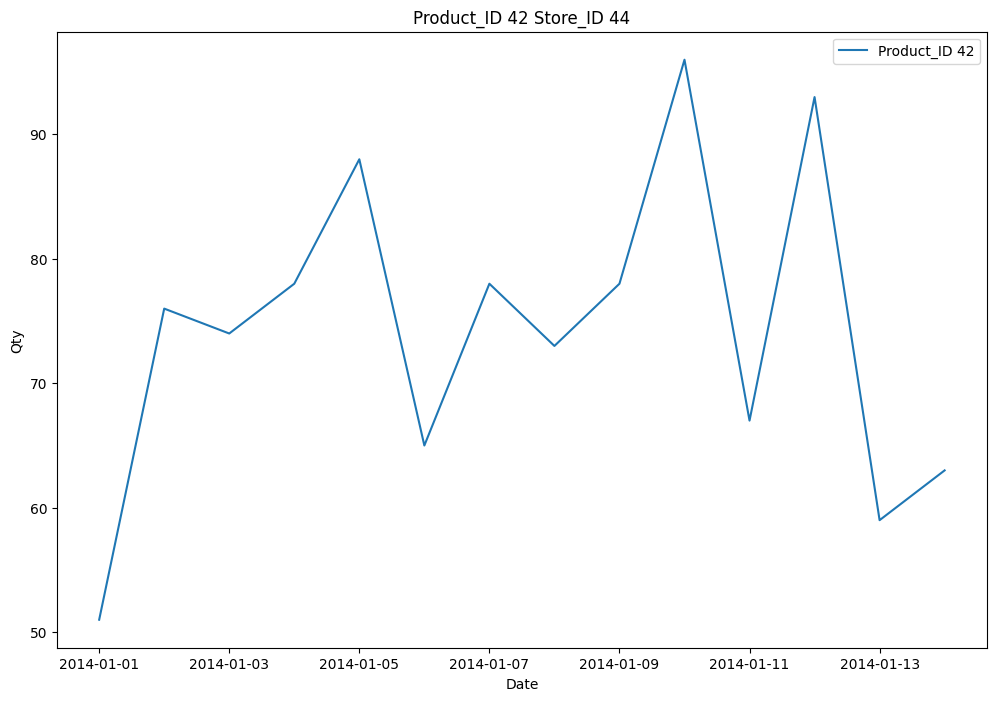

In [58]:
import matplotlib.pyplot as plt

# 대상 상품 코드
target_product = 42
target_store = 44

# 대상 매장 및 대상 상품의 판매량 데이터
target_sales = sales[(sales['Store_ID'] == target_store) & (sales['Product_ID'] == target_product)]

# 날짜를 인덱스로 설정
target_sales.set_index('Date', inplace=True)

# 14일간의 데이터
target_sales_14day = target_sales.head(14)

# 대상 상품의 판매량 추이 시각화
plt.figure(figsize=(12, 8))
plt.plot(target_sales_14day['Qty'], label=f'Product_ID {target_product}')
plt.title(f'Product_ID {target_product} Store_ID {target_store}')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.show()


### 2) 대상 상품의 동일 카테고리의 상품별 판매량 추이

In [54]:
Category_products = products[products['Category'] == 'Grocery']
Category_products.head()

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
4,32,GS001,Seafood,Grocery,3,34
8,10,GE001,EGGS,Grocery,2,5
9,24,GM001,Meats,Grocery,3,17
15,42,FM001,Agricultural products,Grocery,2,5


In [55]:
Category_sales = pd.merge(sales, Category_products, on='Product_ID')

Category_sales.iloc[178850:179000]

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
178850,2016-10-07,3,175.795,32,GS001,Seafood,Grocery,3,34
178851,2016-10-07,4,54.877,32,GS001,Seafood,Grocery,3,34
178852,2016-10-07,5,13.052,32,GS001,Seafood,Grocery,3,34
178853,2016-10-07,6,83.400,32,GS001,Seafood,Grocery,3,34
178854,2016-10-07,7,66.591,32,GS001,Seafood,Grocery,3,34
...,...,...,...,...,...,...,...,...,...
178995,2016-10-09,40,6.000,32,GS001,Seafood,Grocery,3,34
178996,2016-10-09,41,6.000,32,GS001,Seafood,Grocery,3,34
178997,2016-10-09,42,23.628,32,GS001,Seafood,Grocery,3,34
178998,2016-10-09,43,2.000,32,GS001,Seafood,Grocery,3,34


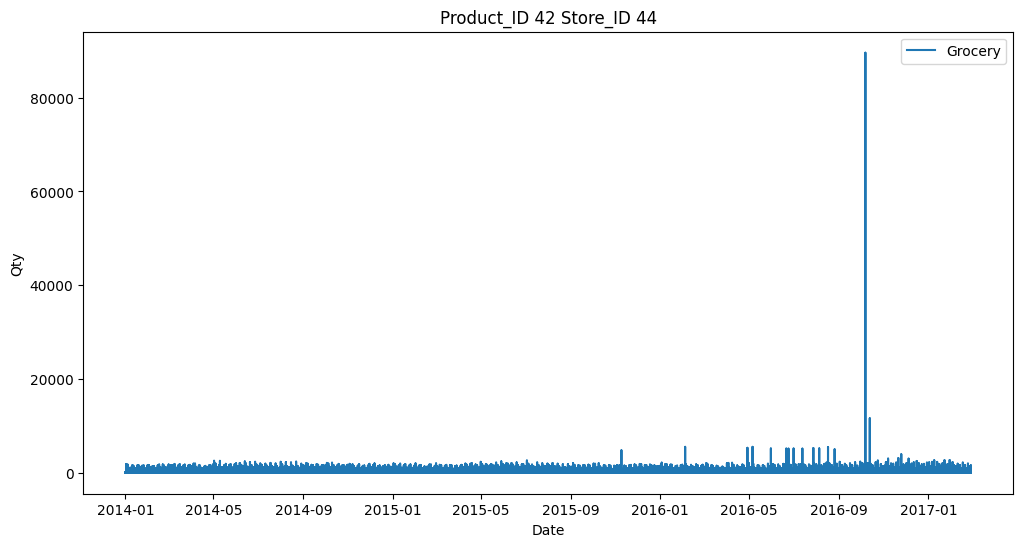

In [41]:
# Grocery 카테고리에 해당하는 상품
Category_products = products[products['Category'] == 'Grocery']

# 상품 데이터와 판매 데이터 병합
Category_sales = pd.merge(sales, Category_products, on='Product_ID')

# 날짜를 인덱스로 설정
Category_sales.set_index('Date', inplace=True)

# 날짜 설정
Category_sales_day = Category_sales['2016-10-01':'2016-10-10']

# 대상 상품의 판매량 추이 시각화
plt.figure(figsize=(12, 6))
plt.plot(Category_sales['Qty'], label='Grocery')
plt.title(f'Product_ID {target_product} Store_ID {target_store}')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.show()





### 3) 휘발류 가격과 상품 판매량 추이 비교

### 4) 구매 고객수와 상품 판매량 추이 비교

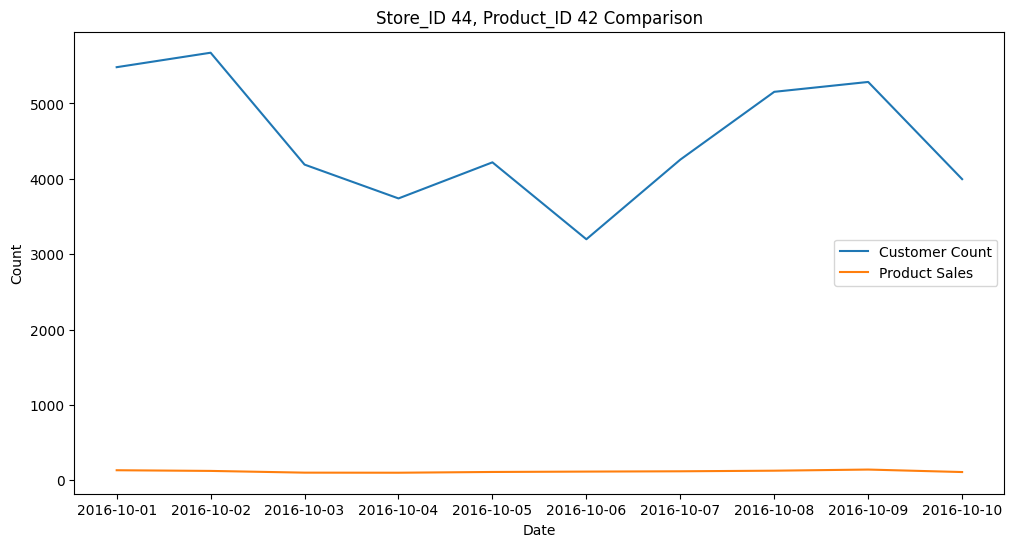

In [62]:

# orders 데이터셋에서 해당 매장의 날짜별 구매 고객수 추출
store_orders = orders[orders['Store_ID'] == target_store]  # 44 매장의 데이터만 필터링합니다.
store_orders['Date'] = pd.to_datetime(store_orders['Date'])  # Date 열을 날짜 형식으로 변환합니다.
store_orders.set_index('Date', inplace=True)  # Date 열을 인덱스로 설정합니다.

# sales 데이터셋에서 해당 매장의 해당 상품의 판매량 추출
product_sales = sales[(sales['Store_ID'] == target_store) & (sales['Product_ID'] == target_product)]  # 44 매장과 42 상품의 데이터만 필터링합니다.
product_sales['Date'] = pd.to_datetime(product_sales['Date'])  # Date 열을 날짜 형식으로 변환합니다.
product_sales.set_index('Date', inplace=True)  # Date 열을 인덱스로 설정합니다.

# 날짜 설정
store_orders_day = store_orders['2016-10-01':'2016-10-10']
product_sales_day = product_sales['2016-10-01':'2016-10-10']

# 구매 고객수와 상품 판매량 비교하여 시각화
plt.figure(figsize=(12, 6))
plt.plot(store_orders_day['CustomerCount'], label='Customer Count')
plt.plot(product_sales_day['Qty'], label='Product Sales')
plt.title(f'Store_ID {target_store}, Product_ID {target_product} Comparison')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()


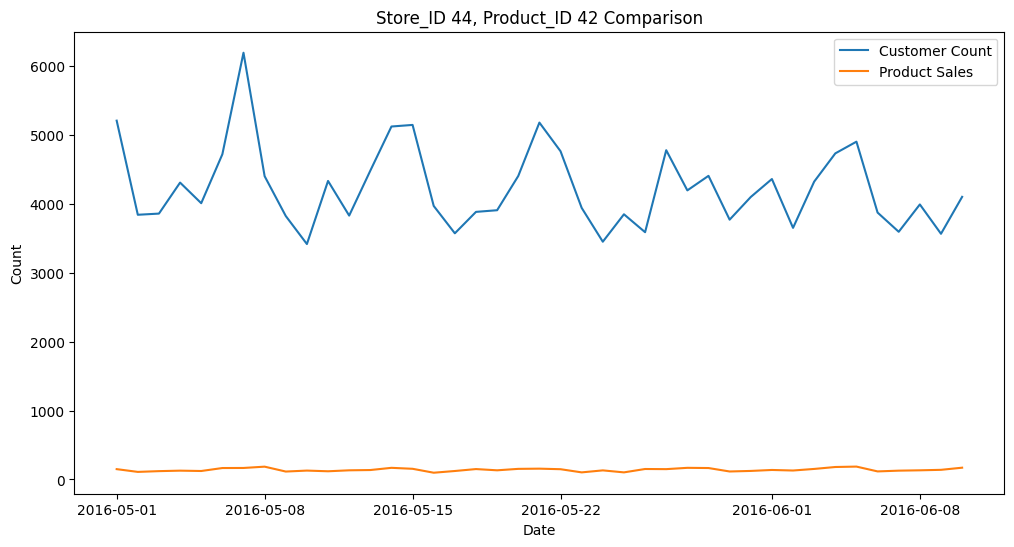

In [67]:
# 날짜 설정
store_orders_day = store_orders['2016-5-01':'2016-6-10']
product_sales_day = product_sales['2016-5-01':'2016-6-10']

# 구매 고객수와 상품 판매량 비교하여 시각화
plt.figure(figsize=(12, 6))
plt.plot(store_orders_day['CustomerCount'], label='Customer Count')
plt.plot(product_sales_day['Qty'], label='Product Sales')
plt.title(f'Store_ID {target_store}, Product_ID {target_product} Comparison')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

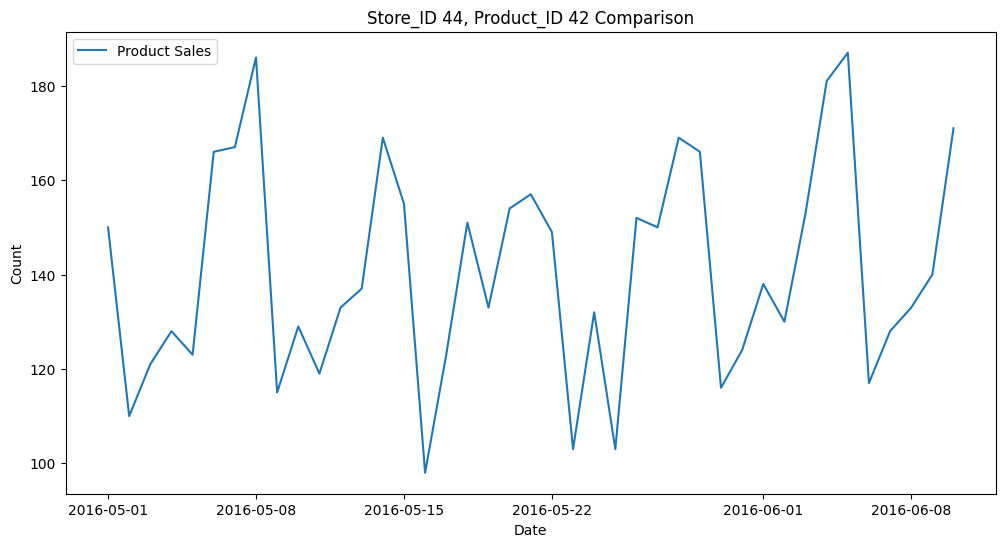

In [68]:

# 구매 고객수와 상품 판매량 비교하여 시각화
plt.figure(figsize=(12, 6))
plt.plot(product_sales_day['Qty'], label='Product Sales')
plt.title(f'Store_ID {target_store}, Product_ID {target_product} Comparison')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

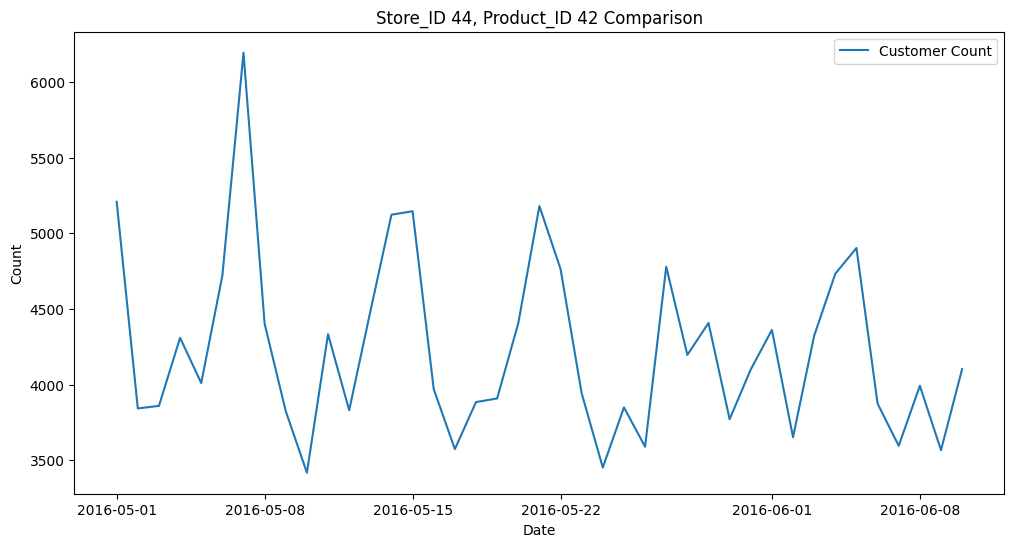

In [69]:
# 구매 고객수와 상품 판매량 비교하여 시각화
plt.figure(figsize=(12, 6))
plt.plot(store_orders_day['CustomerCount'], label='Customer Count')
plt.title(f'Store_ID {target_store}, Product_ID {target_product} Comparison')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

## **(2) 시계열 패턴 찾아보기2**

* 변화량과 비교해보기

### 1) 대상 매장(44), 대상 상품의 판매량 추이

In [72]:
# 대상 매장 및 대상 상품의 판매량 데이터
selected_sales = sales[(sales['Store_ID'] == target_store) & (sales['Product_ID'] == target_product)]

# 날짜를 인덱스로 설정
selected_sales.set_index('Date', inplace=True)

# 전날의 판매량을 가져와서 새로운 컬럼에 추가
selected_sales['PrevDayQty'] = selected_sales['Qty'].shift(1)

# 전날과의 판매량 변화를 계산하여 새로운 컬럼에 추가
selected_sales['QtyChange'] = selected_sales['Qty'] - selected_sales['PrevDayQty']

# 결과 확인
selected_sales.head()

,Store_ID,Qty,Product_ID,PrevDayQty,QtyChange
Date,,,,,
2014-01-01,44,51.0,42,NaN,NaN
2014-01-02,44,76.0,42,51.0,25.0
2014-01-03,44,74.0,42,76.0,-2.0
2014-01-04,44,78.0,42,74.0,4.0
2014-01-05,44,88.0,42,78.0,10.0


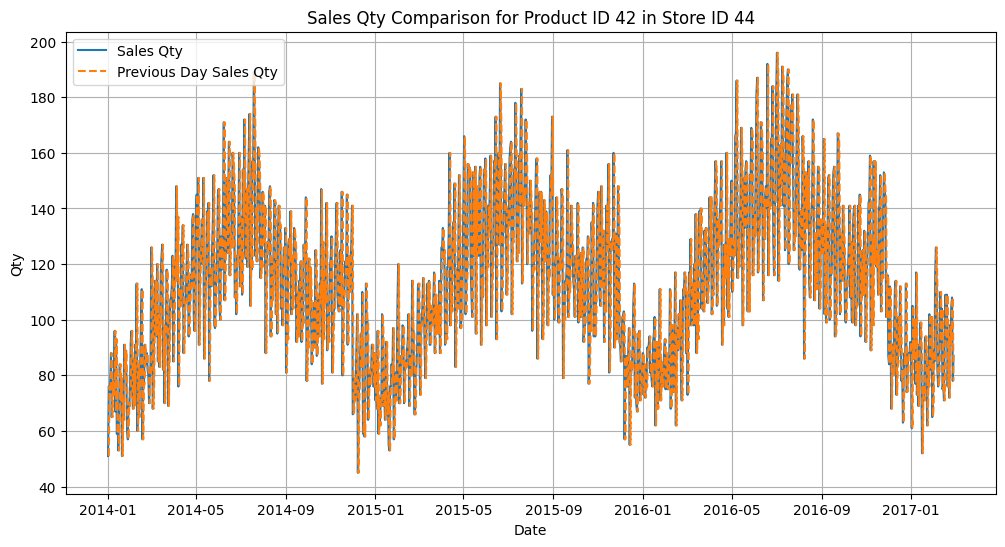

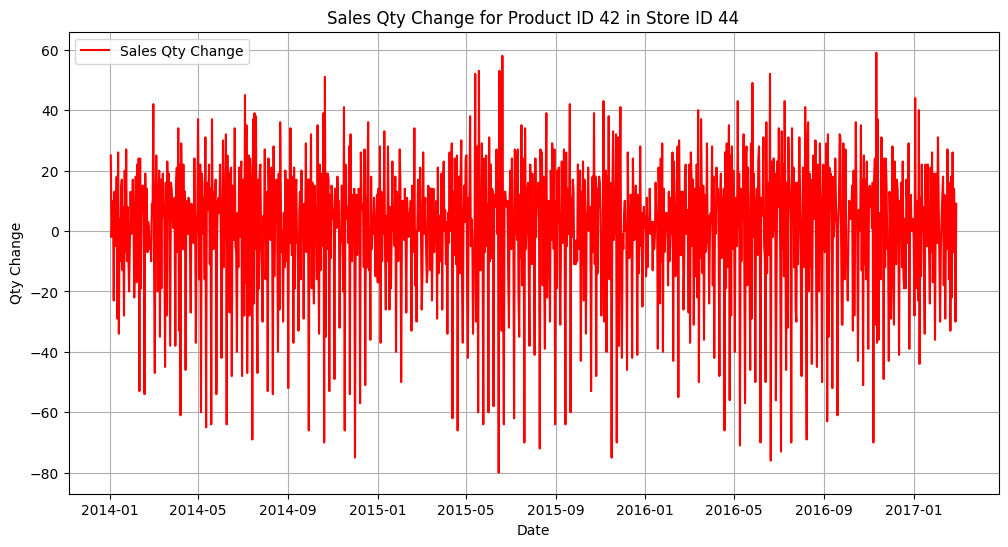

In [80]:

# 대상 상품의 판매량 추이 시각화
plt.figure(figsize=(12, 6))
plt.plot(selected_sales.index, selected_sales['Qty'], label='Sales Qty')
plt.plot(selected_sales.index, selected_sales['PrevDayQty'], label='Previous Day Sales Qty', linestyle='--')
plt.title(f'Sales Qty Comparison for Product ID {target_product} in Store ID {target_store}')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.grid(True)
plt.show()

# 판매량 변화 시각화
plt.figure(figsize=(12, 6))
plt.plot(selected_sales.index, selected_sales['QtyChange'], label='Sales Qty Change', color='red')
plt.title(f'Sales Qty Change for Product ID {target_product} in Store ID {target_store}')
plt.xlabel('Date')
plt.ylabel('Qty Change')
plt.legend()
plt.grid(True)
plt.show()

### 2) 요일별 변화량 비교

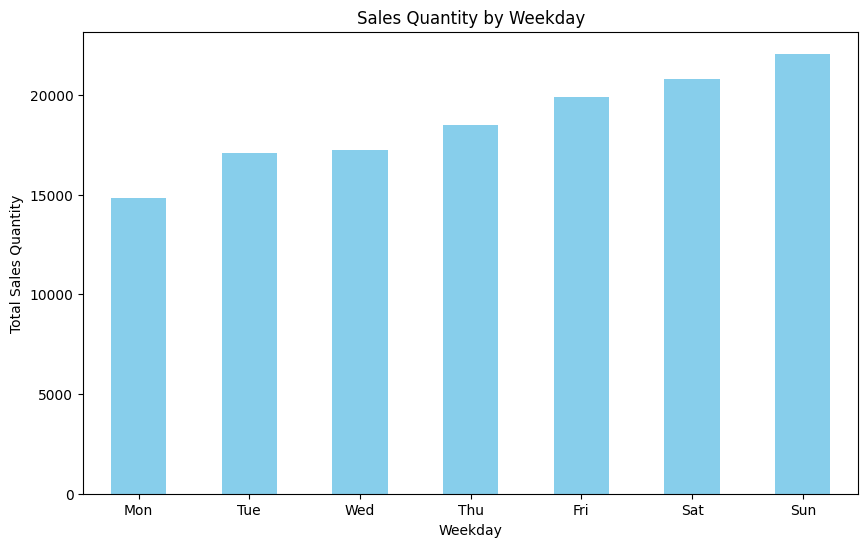

In [84]:

# 대상 매장 및 상품에 대한 판매량 데이터 선택
selected_sales = sales[(sales['Store_ID'] == target_store) & (sales['Product_ID'] == target_product)]

# 날짜를 인덱스로 설정
selected_sales.set_index('Date', inplace=True)

# 요일 정보 추가
selected_sales['Weekday'] = selected_sales.index.dayofweek

# 각 요일의 판매량 계산
weekday_sales = selected_sales.groupby('Weekday')['Qty'].sum()

# 요일별 판매량 시각화
plt.figure(figsize=(10, 6))
weekday_sales.plot(kind='bar', color='skyblue')
plt.title('Qty by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Total Sales Quantity')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()


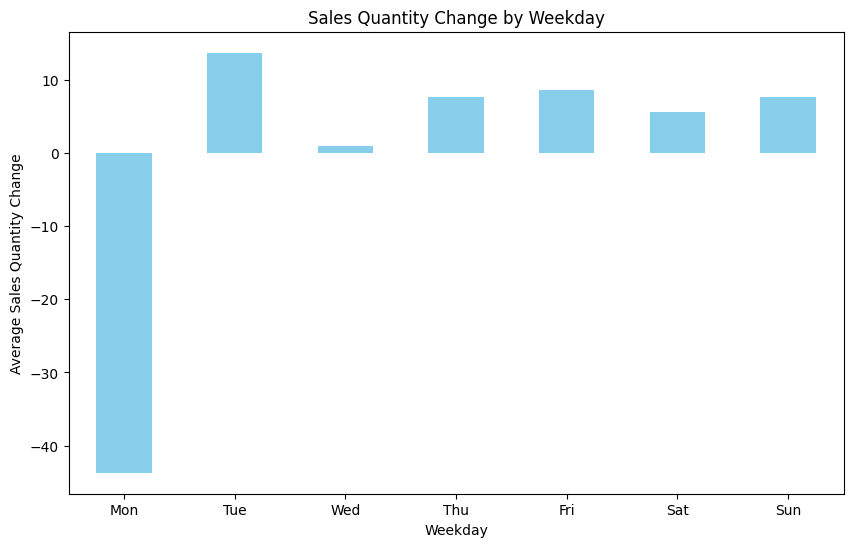

In [83]:

# 대상 매장 및 상품에 대한 판매량 데이터 선택
selected_sales = sales[(sales['Store_ID'] == target_store) & (sales['Product_ID'] == target_product)]

# 날짜를 인덱스로 설정
selected_sales.set_index('Date', inplace=True)

# 요일 정보 추가
selected_sales['Weekday'] = selected_sales.index.dayofweek

# 전날의 판매량을 새로운 열로 추가
selected_sales['PrevDayQty'] = selected_sales['Qty'].shift(1)

# 전날과의 판매량 변화를 계산하여 새로운 열로 추가
selected_sales['QtyChange'] = selected_sales['Qty'] - selected_sales['PrevDayQty']

# 각 요일의 평균 판매량 변화량 계산
weekday_change = selected_sales.groupby('Weekday')['QtyChange'].mean()

# 요일별 판매량 변화를 시각화
plt.figure(figsize=(10, 6))
weekday_change.plot(kind='bar', color='skyblue')
plt.title('Sales Quantity Change by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Sales Quantity Change')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()


### 3) 시계열 데이터 분해

In [85]:
def decomp_plot(Product_ID, sdate, edate, period ) :

    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(15, 8))

    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')

    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')

    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

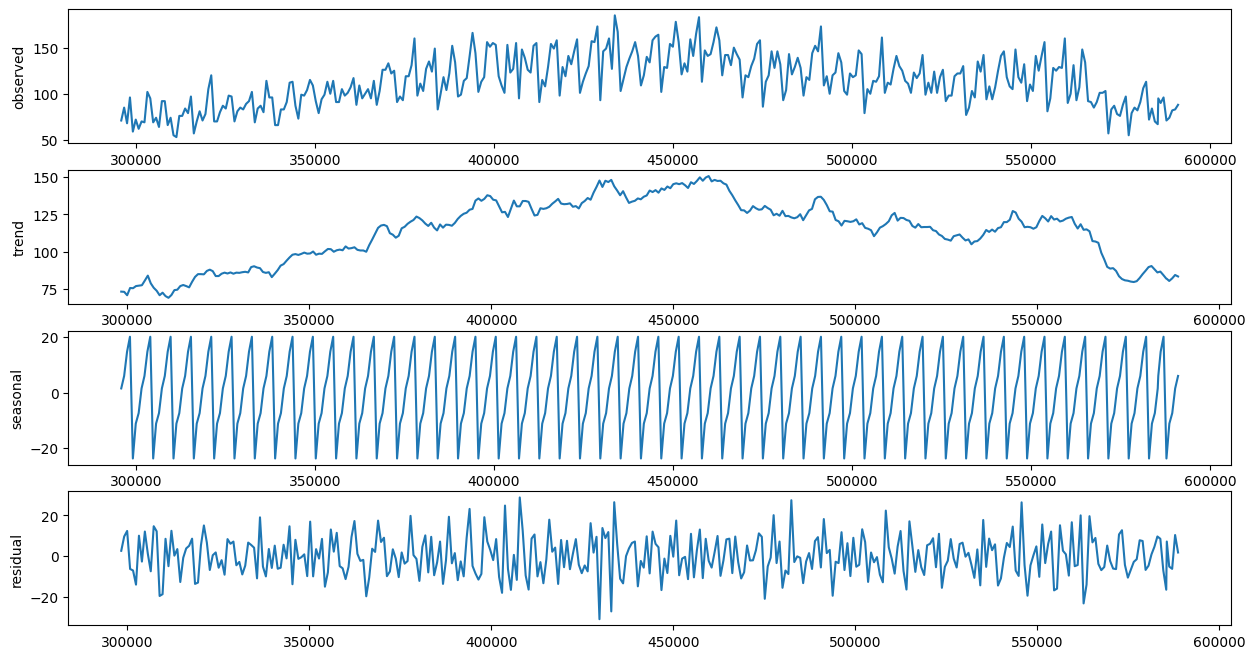

In [88]:
Product_ID = 42
sdate = '2015-01-01'
edate = '2016-01-01'
period = 7  # 주별 주기로 설정

# 함수 호출 및 시각화
decomp_result = decomp_plot(Product_ID, sdate, edate, period)

### 4) 그 외 패턴 찾아보기

# **3.패턴 정리하기**

* 다양한 탐색을 통해 찾은 시계열 패턴을 적어 봅시다.